# Bibliotecas e Ambiente

In [2]:
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
from capymoa.classifier import (
    LeveragingBagging,
    HoeffdingTree,
    HoeffdingAdaptiveTree,
    AdaptiveRandomForestClassifier,
)
from capymoa.evaluation import (
    ClassificationEvaluator,
    prequential_evaluation, 
    ClassificationWindowedEvaluator,
    prequential_evaluation_multiple_learners,
    prequential_ssl_evaluation
)
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.stream import NumpyStream
from sklearn.preprocessing import LabelEncoder
from py.functions import plot_confusion_matrix, criar_stream
import random
from collections import deque
from capymoa.drift.detectors import DDM, ADWIN, ABCD

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de Avisos 
warnings.filterwarnings('ignore')

# Streams

## Real

### CICDDoS2019

In [4]:
from py.functions import criar_stream

FILE_RAW = r'datasets\CICDDoS2019\data\CICDDoS2019_01_12.csv'
# FILE_RAW = r'datasets\CICDDoS2019\CICDDoS2019_03_11.csv'

TARGET_COL = " Label" # Ajuste se for o CIC-IDS2017 (sem espaço)
TIME_COL = " Timestamp" # Ajuste se for o CIC-IDS2017 (não existe)

# Colunas a serem removidas 
COLS_NAO_FEATURES = [
    'Flow ID', 
    ' Source IP', 
    ' Source Port',
    ' Destination IP', 
    ' Destination Port',
    ' Protocol'
]

TOP_20_FEATURES = [
    'Bwd Packet Length Max',
    'Min Packet Length',
    'Max Packet Length',
    'Packet Length Mean',
    'Packet Length Std',
    'Flow IAT Max',
    'Flow IAT Mean',
    'ACK Flag Count',
    'Fwd Packet Length Max',
    'Fwd Packet Length Mean',
    'Bwd Packet Length Mean',
    'Bwd Packet Length Std',
    'Init_Win_bytes_backward',
    'Bwd Packets/s',
    'Subflow Fwd Bytes',
    'Subflow Bwd Bytes',
    'Flow IAT Std',
    'Fwd IAT Total',
    'Init_Win_bytes_forward',
    'Avg Bwd Segment Size'
]

# Esta função única faz todo o trabalho de Carga, Limpeza, Ordenação e Criação
CICDDoS2019, le_global = criar_stream(
    file_path=FILE_RAW,
    target_label_col=TARGET_COL,
    timestamp_col=TIME_COL,
    cols_para_remover=COLS_NAO_FEATURES,
    features_selecionadas=TOP_20_FEATURES
)

--- Iniciando Pipeline: datasets\CICDDoS2019\data\CICDDoS2019_01_12.csv ---
  [Passo 2/6] Colunas renomeadas.
  [Passo 3/6] Ordenando DataFrame por 'Timestamp'...
  [Passo 4/6] Convertendo valores Infinitos para NaN...
  [Passo 5/6] Removendo colunas, tratando nulos e codificando rótulos...
    - LabelEncoder criado e ajustado. 12 classes encontradas.
    - 7 colunas removidas do conjunto de features.
    - Imputando 3142 valores nulos/infinitos com a MEDIANA...
    - Aplicando seleção de features. Mantendo 20 colunas.
  [Passo 6/6] Criando objeto NumpyStream...
    - Dados finais preparados: X_shape=(93070, 20), y_shape=(93070,).
Stream criado e pronto para uso.


## Sintética

In [3]:
from capymoa.stream.drift import DriftStream, AbruptDrift, GradualDrift
from capymoa.stream.generator import (
    RandomTreeGenerator, 
    SEA, 
    RandomRBFGenerator, 
    RandomRBFGeneratorDrift
)

# Hyperparâmetros padrão
streams = {
    "RTG": RandomTreeGenerator(
        instance_random_seed=1,
        tree_random_seed=1,
        num_classes=2,
        num_nominals=5,
        num_numerics=5,
        num_vals_per_nominal=5,
        max_tree_depth=5,
        first_leaf_level=3,
        leaf_fraction=0.15,
    ),
    
    "RTG_drift": DriftStream(
        stream=[
            RandomTreeGenerator(tree_random_seed=1),
            AbruptDrift(position=1000),
            RandomTreeGenerator(tree_random_seed=2),
            GradualDrift(position=2000, width=500),
            RandomTreeGenerator(tree_random_seed=2),
            AbruptDrift(position=3000),
            RandomTreeGenerator(tree_random_seed=2),
        ]
    ),

    "SEA_drift": DriftStream(
        stream=[
            SEA(function=1),
            AbruptDrift(position=1000),
            SEA(function=2),
            AbruptDrift(position=2000),
            SEA(function=3),
            GradualDrift(position=3000, width=500),
            SEA(function=4),
        ]
    ),

    "RandomRBF": RandomRBFGenerator(
        model_random_seed=1,
        instance_random_seed=1,
        number_of_classes=2,
        number_of_attributes=10,
        number_of_centroids=50,
    ), 

    "RandomRBF_drift": RandomRBFGeneratorDrift(
        model_random_seed=1,
        instance_random_seed=1,
        number_of_classes=2,
        number_of_attributes=10,
        number_of_centroids=50,
        number_of_drifting_centroids=4,
        magnitude_of_change=0.0,
    ),

    "Robust_Drift": DriftStream(
        stream=[
            # 0-2000
            RandomRBFGenerator(
                model_random_seed=1, 
                instance_random_seed=1, 
                number_of_classes=2, 
                number_of_attributes=10, 
                number_of_centroids=50
            ),
            # 2000-4000 (Testa DDM/ADWIN)
            AbruptDrift(position=2000),
            RandomTreeGenerator(
                tree_random_seed=1, 
                instance_random_seed=1, 
                num_classes=2, 
                num_nominals=0, 
                num_numerics=10
            ),
            # 4000-6000 (Testa ABCD)
            AbruptDrift(position=4000),
            RandomRBFGenerator(
                model_random_seed=2, 
                instance_random_seed=1, 
                number_of_classes=2, 
                number_of_attributes=10, 
                number_of_centroids=20
            ),
            # 6000-8000 (Testa DDM/ADWIN)
            AbruptDrift(position=6000),
            RandomTreeGenerator(
                tree_random_seed=2, 
                instance_random_seed=1, 
                num_classes=2, 
                num_nominals=0, 
                num_numerics=10
            ),
            # 8000-10000 (Testa ABCD)
            GradualDrift(position=8000, width=1000),
            RandomRBFGeneratorDrift(
                model_random_seed=4, 
                instance_random_seed=1, 
                number_of_attributes=10, 
                number_of_drifting_centroids=20, 
                magnitude_of_change=0.5
            )
        ]
    )

}

# Avaliando um único fluxo usando múltiplos Algoritmos

## Implementação Própria

Este *loop* implementa uma metodologia de avaliação *prequencial* (test-then-train) para múltiplos modelos simultaneamente.

A lógica funciona da seguinte forma:

1.  **Iteração Única (Stream):** O *loop* `while` avança instância por instância (`count`) pelo *stream* de dados.
2.  **Iteração Dinâmica (Modelos):** Para **cada** instância (ex: `Instância 0`), um *loop* `for` interno passa essa mesma instância por **todos** os modelos definidos no dicionário `models_to_test`.
3.  **Estado Encapsulado:** O dicionário armazena o "estado" de cada modelo (o próprio modelo, seus detectores de *drift* e suas listas de resultados).
4.  **Lógica Unificada:** Dentro do `for`, a lógica de `predict()`, `train()`, e detecção de *drift* é aplicada individualmente a cada modelo antes de avançar para a próxima instância do *stream*.

Isso garante que todos os modelos sejam treinados e avaliados exatamente sob as mesmas condições, na mesma ordem de dados.

### Hiperparâmetros

Os hiperparâmetros dos modelos devem ser ajustados no arquivo ``py/models.py``

In [5]:
from py.models import get_models

MAX_INSTANCES = 93070
WINDOW_SIZE = 1000
DELAY_LENGTH = 500
LABEL_PROBABILITY = 0.75

# Para alterar entre as streams sintética e real
stream = CICDDoS2019
# stream = streams["Robust_Drift"]
print(stream.get_schema())

@relation 'datasets\\CICDDoS2019\\data\\CICDDoS2019_01_12.csv'

@attribute attrib_0 numeric
@attribute attrib_1 numeric
@attribute attrib_2 numeric
@attribute attrib_3 numeric
@attribute attrib_4 numeric
@attribute attrib_5 numeric
@attribute attrib_6 numeric
@attribute attrib_7 numeric
@attribute attrib_8 numeric
@attribute attrib_9 numeric
@attribute attrib_10 numeric
@attribute attrib_11 numeric
@attribute attrib_12 numeric
@attribute attrib_13 numeric
@attribute attrib_14 numeric
@attribute attrib_15 numeric
@attribute attrib_16 numeric
@attribute attrib_17 numeric
@attribute attrib_18 numeric
@attribute attrib_19 numeric
@attribute Label {0,1,2,3,4,5,6,7,8,9,10,11}

@data


### Supervisionado


Modelo: LeveragingBagging
  Accuracy: 98.0542
  F1_Score: 95.4520
  Precision: 95.4845
  Recall: 95.4196
  Kappa: 96.8154
  Kappa_m: 94.9982
  Kappa_t: 76.7821


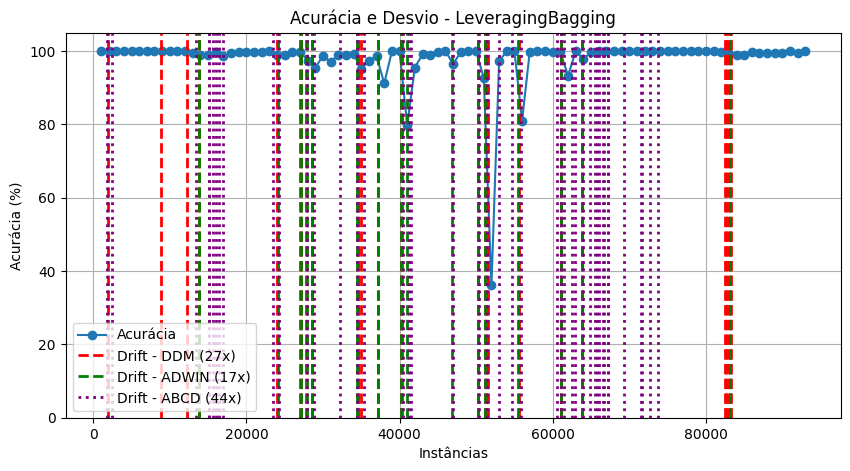


Modelo: HoeffdingAdaptiveTree
  Accuracy: 99.2017
  F1_Score: 97.9254
  Precision: 98.0408
  Recall: 97.8102
  Kappa: 98.6931
  Kappa_m: 97.9479
  Kappa_t: 90.4744


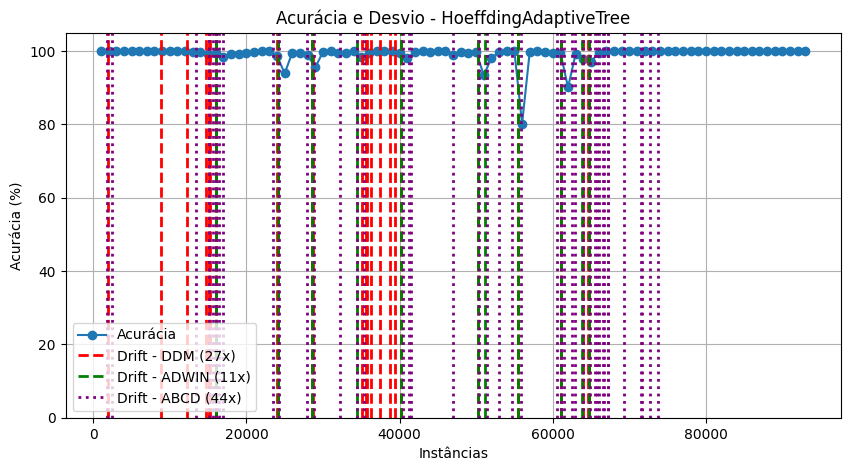


Modelo: AdaptiveRandomForest
  Accuracy: 99.7282
  F1_Score: 99.4186
  Precision: 99.4153
  Recall: 99.4218
  Kappa: 99.5550
  Kappa_m: 99.3012
  Kappa_t: 96.7564


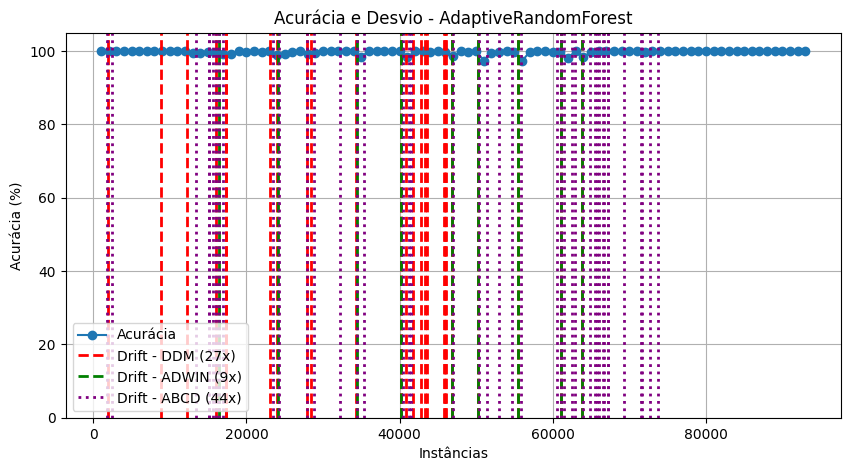


Modelo: HoeffdingTree
  Accuracy: 94.5063
  F1_Score: 87.9735
  Precision: 87.5340
  Recall: 88.4175
  Kappa: 91.0435
  Kappa_m: 85.8784
  Kappa_t: 34.4487


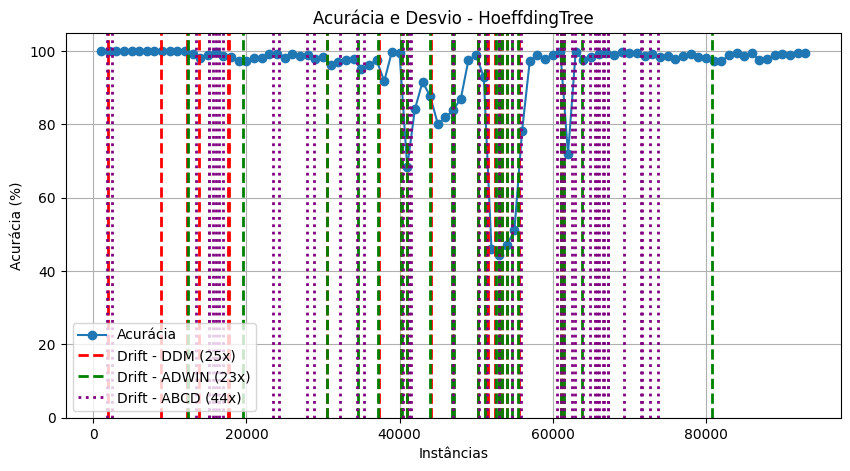

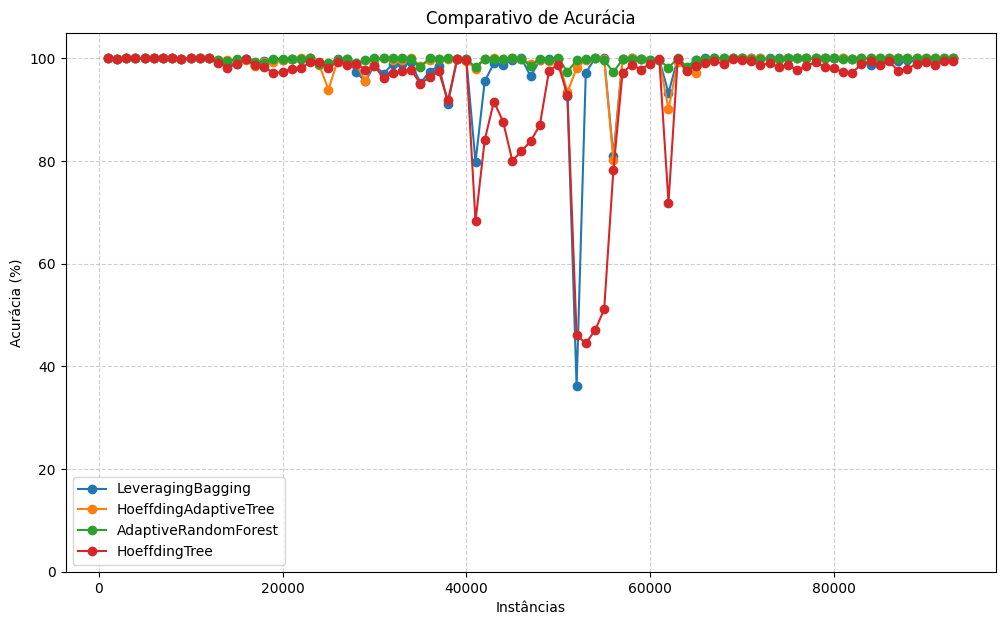

In [6]:
models_to_test = get_models(stream.schema, WINDOW_SIZE, delay_length=DELAY_LENGTH)
instance_count_history = [] 
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    
    # Verifica se estamos no final de uma janela (para plotar)
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    # Itera sobre cada modelo e aplica a mesma lógica
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        # Predict
        prediction = model.predict(instance)
        try:
            prediction_value = prediction[0]
        except (IndexError, TypeError):
            prediction_value = prediction 
        
        # Evaluate 
        state["evaluator"].update(instance.y_index, prediction_value)
        
        # Error (para Drifts e Acurácia de Janela)
        error = 0 if prediction_value == instance.y_index else 1
        state["window_errors"].append(error)
        
        # Drift Detection (DDM)
        state["drift_ddm"].add_element(error)
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        # Drift Detection (ADWIN)
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        # Drift Detection (ABCD)
        state["drift_ABCD"].add_element(instance)
        if state["drift_ABCD"].detected_change():
            state["results_drift_ABCD"].append(count)
            state["drift_ABCD"].reset()
            
        # Train
        model.train(instance)
        
        # Coleta de Acurácia (na borda da janela)
        if is_window_boundary:
            if state["window_errors"]:
                mean_error = np.mean(state["window_errors"])
                accuracy_pct = (1.0 - mean_error) * 100
                state["results_accuracy"].append(accuracy_pct)
            else:
                state["results_accuracy"].append(100.0)
            
            state["window_errors"].clear() # Lógica de janela "tumbling"
            
    # Adiciona ao eixo X compartilhado
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

# Resultados Cumulativos 
for model_name, state in models_to_test.items():
    print(f"\nModelo: {model_name}")
    print(f"  Accuracy: {state['evaluator'].accuracy():.4f}")
    print(f"  F1_Score: {state['evaluator'].f1_score():.4f}")
    print(f"  Precision: {state['evaluator'].precision():.4f}")
    print(f"  Recall: {state['evaluator'].recall():.4f}")
    print(f"  Kappa: {state['evaluator'].kappa():.4f}")
    print(f"  Kappa_m: {state['evaluator'].kappa_m():.4f}")
    print(f"  Kappa_t: {state['evaluator'].kappa_t():.4f}")
    # print(f"  Metrics: {state['evaluator'].metrics()}")
    # print(f"  Metrics_dict: {state['evaluator'].metrics_dict()}")
    # print(f"  Metrics_header: {state['evaluator'].metrics_header()}")
    # print(f"  Metrics_per_window: {state['evaluator'].metrics_per_window()}")

    plt.figure(figsize=(10, 5))
    plt.plot(instance_count_history, state['results_accuracy'], 'o-', label='Acurácia')
    drift_count_ddm = len(state['results_drift_ddm'])
    drift_count_adwin = len(state['results_drift_adwin'])
    drift_count_ABCD = len(state["results_drift_ABCD"])
    plt.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='r', linestyle='--', 
               linewidth=2, label=f'Drift - DDM ({drift_count_ddm}x)')
    plt.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='g', linestyle='--', 
               linewidth=2, label=f'Drift - ADWIN ({drift_count_adwin}x)')
    plt.vlines(x=state['results_drift_ABCD'], ymin=0, ymax=105, color='purple', linestyle=':', 
               linewidth=2, label=f'Drift - ABCD ({drift_count_ABCD}x)')
    plt.title(f'Acurácia e Desvio - {model_name}')
    plt.xlabel('Instâncias')
    plt.ylabel('Acurácia (%)')
    plt.ylim(0, 105) 
    plt.grid(True)
    plt.legend()
    plt.show()

# Gráfico Comparativo (Apenas Acurácia)
plt.figure(figsize=(12, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_accuracy'], 'o-', label=model_name)
plt.title('Comparativo de Acurácia')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

### Semi-supervised Learning (SSL)


Modelo: LeveragingBagging
  Accuracy: 84.8125
  F1_Score: 84.0590
  Precision: 85.1121
  Recall: 83.0317
  Kappa: 67.6272
  Kappa_m: 62.0905
  Kappa_t: 68.3099

Modelo: HoeffdingAdaptiveTree
  Accuracy: 84.4250
  F1_Score: 83.6348
  Precision: 84.5388
  Recall: 82.7498
  Kappa: 66.8837
  Kappa_m: 61.1232
  Kappa_t: 67.5013

Modelo: AdaptiveRandomForest
  Accuracy: 85.1125
  F1_Score: 84.3755
  Precision: 85.3785
  Recall: 83.3958
  Kappa: 68.3003
  Kappa_m: 62.8393
  Kappa_t: 68.9358

Modelo: HoeffdingTree
  Accuracy: 84.0000
  F1_Score: 83.2230
  Precision: 84.5743
  Recall: 81.9142
  Kappa: 65.7046
  Kappa_m: 60.0624
  Kappa_t: 66.6145


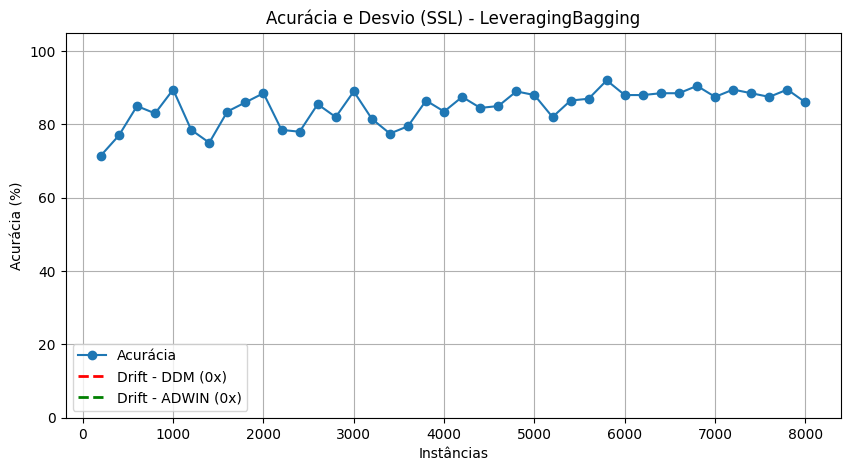

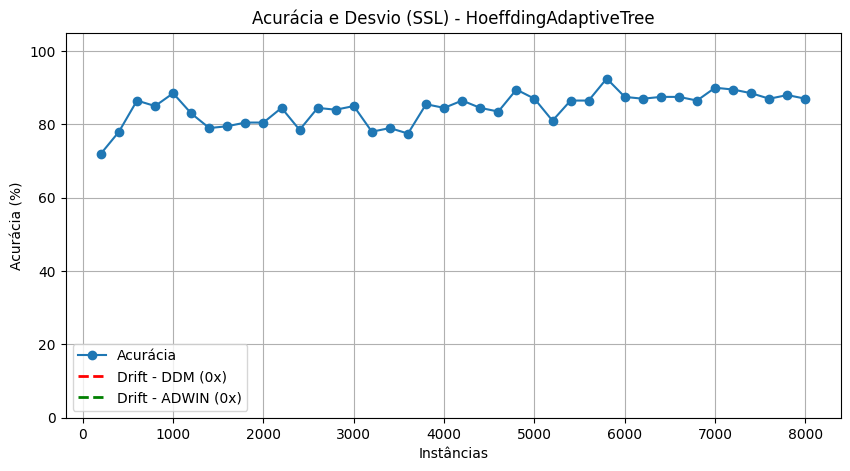

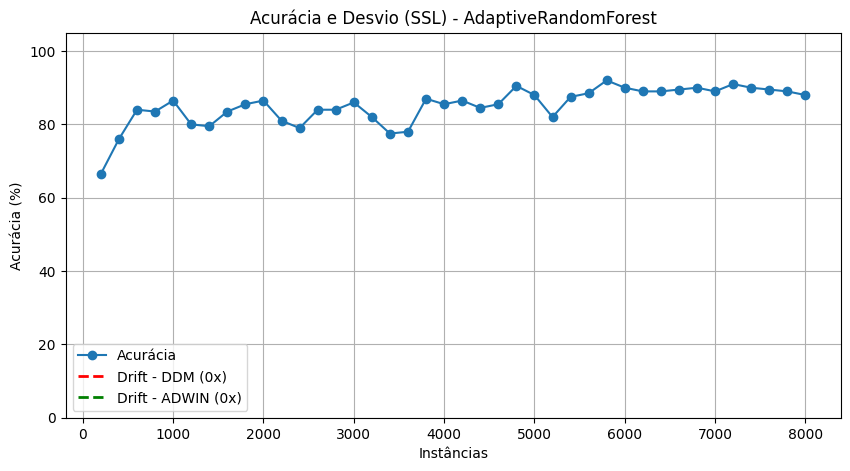

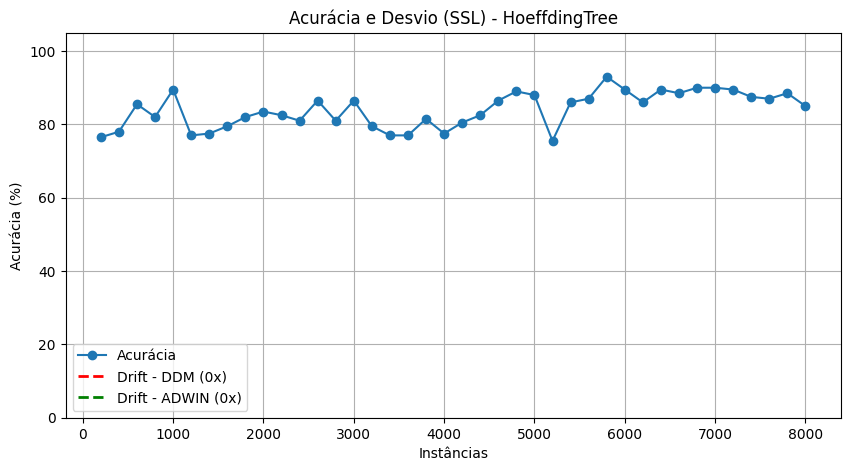

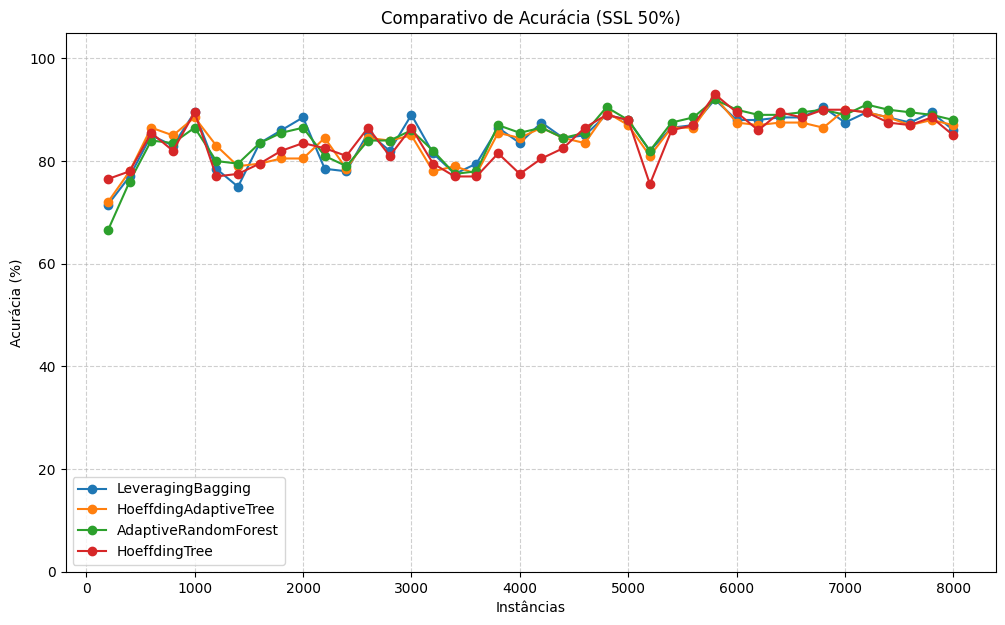

In [186]:
models_to_test = get_models(stream.schema, WINDOW_SIZE, delay_length=DELAY_LENGTH)
instance_count_history = [] 
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        try:
            prediction_value = prediction[0]
        except (IndexError, TypeError):
            prediction_value = prediction 
        
        state["evaluator"].update(instance.y_index, prediction_value)
        
        error = 0 if prediction_value == instance.y_index else 1
        state["window_errors"].append(error)
        
        state["drift_ddm"].add_element(error)
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        # Drift Detection (ABCD)
        state["drift_ABCD"].add_element(instance)
        if state["drift_ABCD"].detected_change():
            state["results_drift_ABCD"].append(count)
            state["drift_ABCD"].reset()
            
        # O modelo só treina se o "sorteio" (random) permitir
        if random.random() <= LABEL_PROBABILITY:
            model.train(instance)

        if is_window_boundary:
            if state["window_errors"]:
                mean_error = np.mean(state["window_errors"])
                accuracy_pct = (1.0 - mean_error) * 100
                state["results_accuracy"].append(accuracy_pct)
            else:
                state["results_accuracy"].append(100.0)
            
            state["window_errors"].clear() 
            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

# Resultados Cumulativos 
for model_name, state in models_to_test.items():
    print(f"\nModelo: {model_name}")
    print(f"  Accuracy: {state['evaluator'].accuracy():.4f}")
    print(f"  F1_Score: {state['evaluator'].f1_score():.4f}")
    print(f"  Precision: {state['evaluator'].precision():.4f}")
    print(f"  Recall: {state['evaluator'].recall():.4f}")
    print(f"  Kappa: {state['evaluator'].kappa():.4f}")
    print(f"  Kappa_m: {state['evaluator'].kappa_m():.4f}")
    print(f"  Kappa_t: {state['evaluator'].kappa_t():.4f}")
    # print(f"  Metrics: {state['evaluator'].metrics()}")
    # print(f"  Metrics_dict: {state['evaluator'].metrics_dict()}")
    # print(f"  Metrics_header: {state['evaluator'].metrics_header()}")
    # print(f"  Metrics_per_window: {state['evaluator'].metrics_per_window()}")

for model_name, state in models_to_test.items():
    plt.figure(figsize=(10, 5))
    plt.plot(instance_count_history, state['results_accuracy'], 'o-', label='Acurácia')
    drift_count_ddm = len(state['results_drift_ddm'])
    drift_count_adwin = len(state['results_drift_adwin'])
    plt.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='r', linestyle='--', 
               linewidth=2, label=f'Drift - DDM ({drift_count_ddm}x)')
    plt.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='g', linestyle='--', 
               linewidth=2, label=f'Drift - ADWIN ({drift_count_adwin}x)')
    plt.title(f'Acurácia e Desvio (SSL) - {model_name}')
    plt.xlabel('Instâncias')
    plt.ylabel('Acurácia (%)')
    plt.ylim(0, 105) 
    plt.grid(True)
    plt.legend()
    plt.show()

plt.figure(figsize=(12, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_accuracy'], 'o-', label=model_name)
plt.title(f'Comparativo de Acurácia (SSL {LABEL_PROBABILITY*100:.0f}%)')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

### SSL com Delay


Modelo: LeveragingBagging
  Accuracy: 80.3375
  F1_Score: 79.3426
  Precision: 79.7166
  Recall: 78.9722
  Kappa: 58.5917
  Kappa_m: 50.8898
  Kappa_t: 58.8112

Modelo: HoeffdingAdaptiveTree
  Accuracy: 80.1625
  F1_Score: 79.3121
  Precision: 79.3571
  Recall: 79.2672
  Kappa: 58.6225
  Kappa_m: 50.4527
  Kappa_t: 58.4446

Modelo: AdaptiveRandomForest
  Accuracy: 81.2125
  F1_Score: 80.2970
  Precision: 80.5831
  Recall: 80.0130
  Kappa: 60.5379
  Kappa_m: 53.0752
  Kappa_t: 60.6441

Modelo: HoeffdingTree
  Accuracy: 80.9125
  F1_Score: 80.0411
  Precision: 80.1851
  Recall: 79.8977
  Kappa: 60.0666
  Kappa_m: 52.3259
  Kappa_t: 60.0157


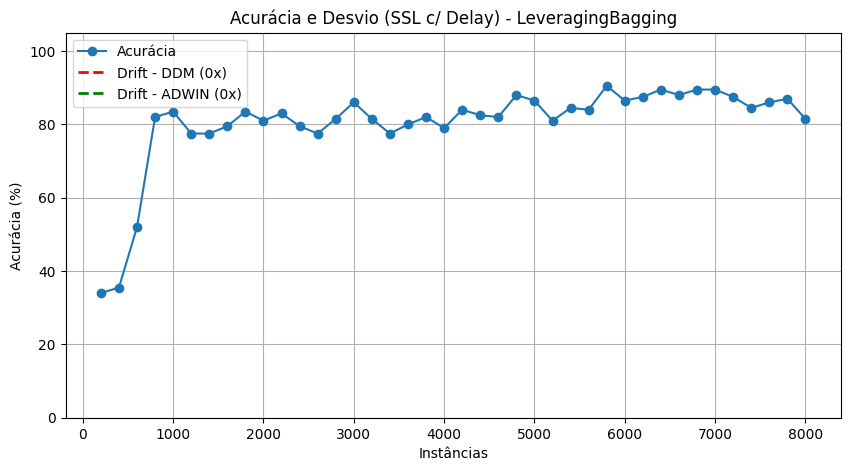

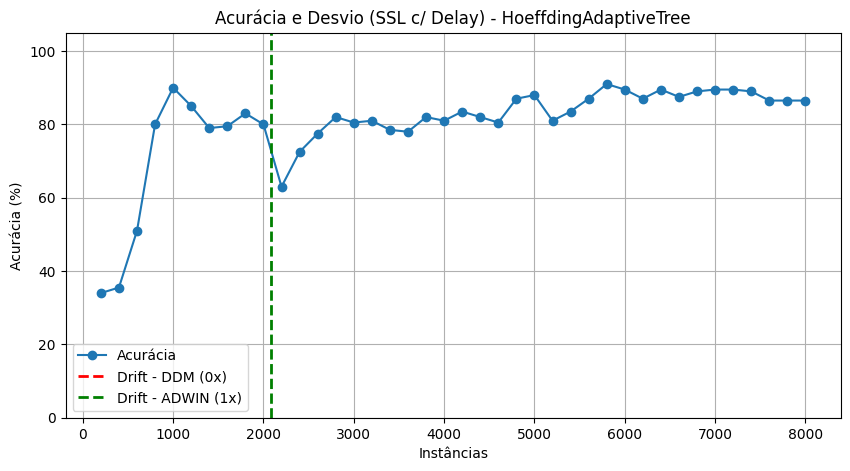

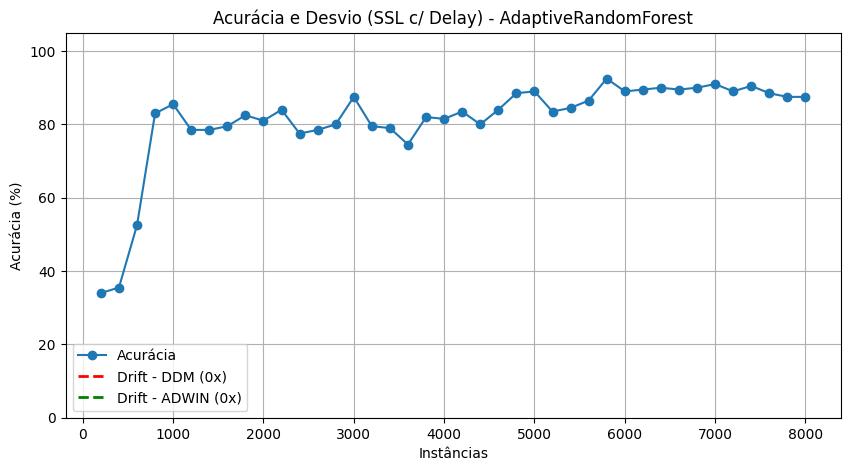

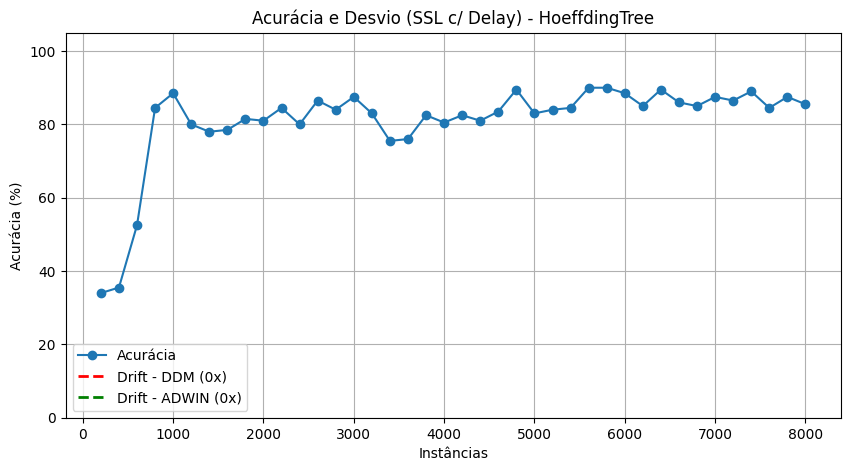

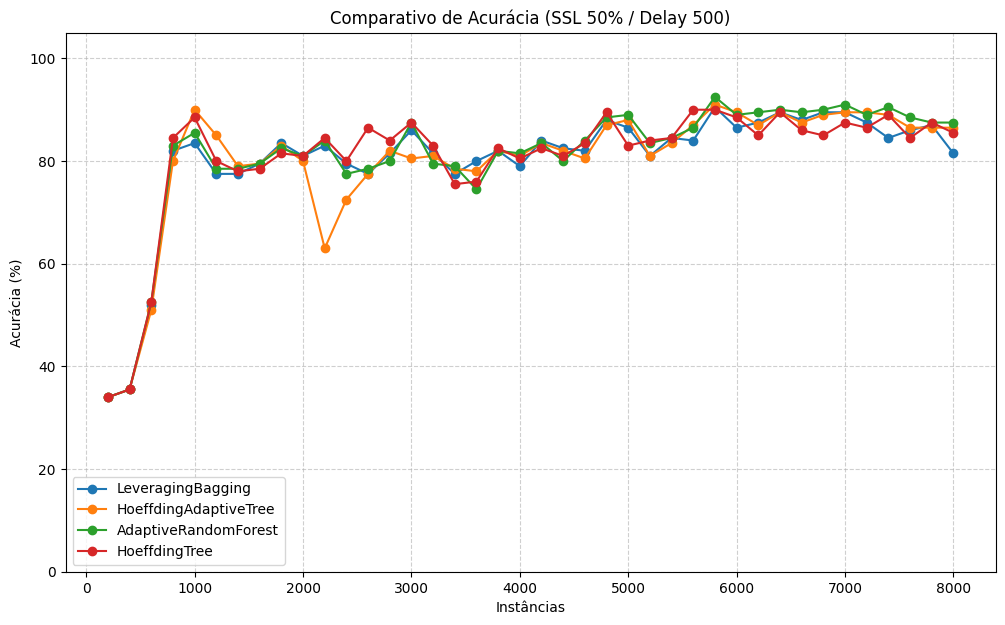

In [187]:
models_to_test = get_models(stream.schema, WINDOW_SIZE, delay_length=DELAY_LENGTH)
instance_count_history = [] 
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        try:
            prediction_value = prediction[0]
        except (IndexError, TypeError):
            prediction_value = prediction 
        
        state["evaluator"].update(instance.y_index, prediction_value)
        
        error = 0 if prediction_value == instance.y_index else 1
        state["window_errors"].append(error)
        
        state["drift_ddm"].add_element(error)
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        # Drift Detection (ABCD)
        state["drift_ABCD"].add_element(instance)
        if state["drift_ABCD"].detected_change():
            state["results_drift_ABCD"].append(count)
            state["drift_ABCD"].reset()
        
        # Armazenar na fila 
        queue = state["prediction_queue"] # Pega a fila específica deste modelo
        if random.random() <= LABEL_PROBABILITY:
            queue.append(instance) # Armazena a instância se o rótulo estiver disponível
        else:
            queue.append(None)     # Armazena None para manter o timing do delay
            
        # Treinar com Atraso (Lógica do Delay)
        if len(queue) == DELAY_LENGTH:
            delayed_item = queue.popleft() # Pega o item mais antigo
            
            if delayed_item is not None:
                # Só treina se o item não for None (ou seja, se o rótulo foi salvo)
                model.train(delayed_item)

        if is_window_boundary:
            if state["window_errors"]:
                mean_error = np.mean(state["window_errors"])
                accuracy_pct = (1.0 - mean_error) * 100
                state["results_accuracy"].append(accuracy_pct)
            else:
                state["results_accuracy"].append(100.0)
            
            state["window_errors"].clear() 
            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

# Resultados Cumulativos 
for model_name, state in models_to_test.items():
    print(f"\nModelo: {model_name}")
    print(f"  Accuracy: {state['evaluator'].accuracy():.4f}")
    print(f"  F1_Score: {state['evaluator'].f1_score():.4f}")
    print(f"  Precision: {state['evaluator'].precision():.4f}")
    print(f"  Recall: {state['evaluator'].recall():.4f}")
    print(f"  Kappa: {state['evaluator'].kappa():.4f}")
    print(f"  Kappa_m: {state['evaluator'].kappa_m():.4f}")
    print(f"  Kappa_t: {state['evaluator'].kappa_t():.4f}")
    # print(f"  Metrics: {state['evaluator'].metrics()}")
    # print(f"  Metrics_dict: {state['evaluator'].metrics_dict()}")
    # print(f"  Metrics_header: {state['evaluator'].metrics_header()}")
    # print(f"  Metrics_per_window: {state['evaluator'].metrics_per_window()}")

for model_name, state in models_to_test.items():
    plt.figure(figsize=(10, 5))
    plt.plot(instance_count_history, state['results_accuracy'], 'o-', label='Acurácia')
    drift_count_ddm = len(state['results_drift_ddm'])
    drift_count_adwin = len(state['results_drift_adwin'])
    plt.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='r', linestyle='--', 
               linewidth=2, label=f'Drift - DDM ({drift_count_ddm}x)')
    plt.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='g', linestyle='--', 
               linewidth=2, label=f'Drift - ADWIN ({drift_count_adwin}x)')
    plt.title(f'Acurácia e Desvio (SSL c/ Delay) - {model_name}')
    plt.xlabel('Instâncias')
    plt.ylabel('Acurácia (%)')
    plt.ylim(0, 105) 
    plt.grid(True)
    plt.legend()
    plt.show()


plt.figure(figsize=(12, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_accuracy'], 'o-', label=model_name)
plt.title(f'Comparativo de Acurácia (SSL {LABEL_PROBABILITY*100:.0f}% / Delay {DELAY_LENGTH})')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

## Implementação capyMOA

### Modelos

In [18]:
HAT = HoeffdingAdaptiveTree(
    schema=stream.schema,
    random_seed=0, # Padrão (0)
    grace_period=200, # Padrão (200)
    split_criterion='InfoGainSplitCriterion', # Padrão ('InfoGainSplitCriterion')
    confidence=0.01, # Padrão (0.01)
    tie_threshold=0.05, # Padrão (0.05)
    leaf_prediction='NaiveBayesAdaptive',
    nb_threshold=0, # Padrão (0)
    numeric_attribute_observer='GaussianNumericAttributeClassObserver', # Padrão ('GaussianNumericAttributeClassObserver')
    binary_split=False, # Padrão (False)
    max_byte_size=33554432, # Padrão (32MB)
    memory_estimate_period=1000000, # Padrão (1.000.000)
    stop_mem_management=True, # Padrão (True)
    remove_poor_attrs=False, # Padrão (False)
    disable_prepruning=True # Padrão (True)
)

LB = LeveragingBagging(
    schema=stream.schema, 
    CLI=None, # Padrão (None)
    random_seed=1, # Padrão (1)
    base_learner=None, # Padrão (None)
    ensemble_size=100, # Padrão (100)
    minibatch_size=None, # Padrão (None)
    number_of_jobs=None # Padrão (None)
)

ARF = AdaptiveRandomForestClassifier(
    schema=stream.schema,
    CLI=None, # Padrão (None)
    random_seed=1, # Padrão (1)
    base_learner=None, # Padrão (None)
    ensemble_size=100, # Padrão (100)
    max_features=0.6, # Padrão (0.6)
    lambda_param=6.0, # Padrão (6.0)
    minibatch_size=None, # Padrão (None)
    number_of_jobs=1, # Padrão (1)
    drift_detection_method=None, # Padrão (None)
    warning_detection_method=None, # Padrão (None)
    disable_weighted_vote=False, # Padrão (False)
    disable_drift_detection=False, # Padrão (False)
    disable_background_learner=False # Padrão (False)        
)

### Avaliação

LB accuracy = 97.9025 
HAT accuracy = 99.13374999999999 
ARF accuracy = 99.6925


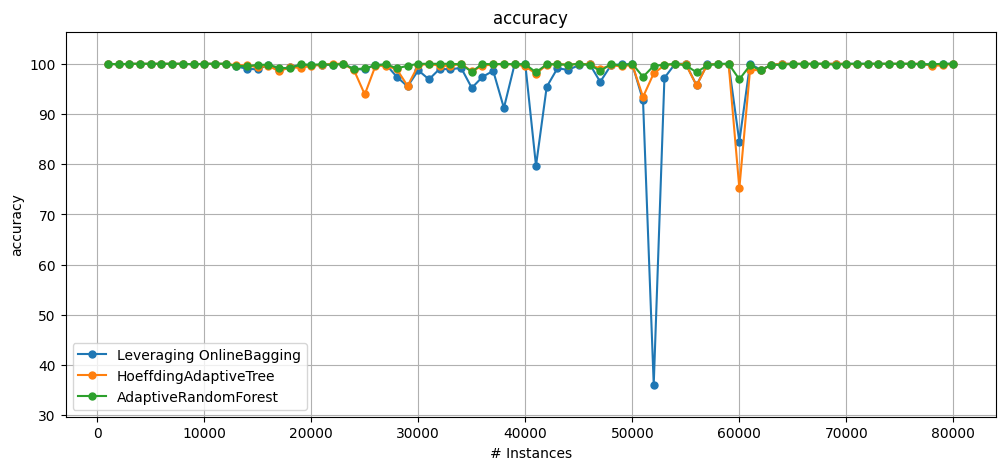

In [19]:
# stream = streams["Robust_Drift"]
stream = CICDDoS2019

learners = {
    "LB": LB,
    "HAT": HAT,
    "ARF": ARF
}

stream.restart()
results = prequential_evaluation_multiple_learners(stream, learners, window_size=1000, max_instances=80000)

print(f"LB accuracy = {results['LB'].cumulative.accuracy()} \nHAT accuracy = {results['HAT'].cumulative.accuracy()} \nARF accuracy = {results['ARF'].cumulative.accuracy()}")
plot_windowed_results(results["LB"], results["HAT"], results["ARF"], metric="accuracy")